# Loop 1 Analysis: Understanding the Gap

## Current Situation
- Best CV score: 146.57
- Target: 68.92
- Gap: 77.65 points (more than 2x target)

## Key Insights from Research
1. Top kernels achieve 67-74 scores using C++ optimizers
2. Ensemble approach combines best solutions from multiple sources
3. Backward propagation improves smaller configs from larger ones
4. Fix direction rotation optimization is essential

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import math

getcontext().prec = 25
scale_factor = Decimal('1e15')

print('Libraries loaded')

Libraries loaded


In [2]:
# Load current best submission and analyze per-n scores
def load_submission(filepath):
    df = pd.read_csv(filepath)
    df['x'] = df['x'].str.strip('s').astype(float)
    df['y'] = df['y'].str.strip('s').astype(float)
    df['deg'] = df['deg'].str.strip('s').astype(float)
    df[['group_id', 'item_id']] = df['id'].str.split('_', n=2, expand=True)
    df['n'] = df['group_id'].astype(int)
    return df

# Load best submission
best_sub = load_submission('/home/code/submission_candidates/candidate_000.csv')
print(f'Loaded submission with {len(best_sub)} rows')

Loaded submission with 20100 rows


In [3]:
# Tree geometry
class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))
        
        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h
        
        initial_polygon = Polygon([
            (Decimal('0.0') * scale_factor, tip_y * scale_factor),
            (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
            (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
            (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
            (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
            (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
            (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
            (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
            (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

def get_side_length(trees):
    if not trees:
        return 0.0
    all_polygons = [t.polygon for t in trees]
    bounds = unary_union(all_polygons).bounds
    minx = bounds[0] / float(scale_factor)
    miny = bounds[1] / float(scale_factor)
    maxx = bounds[2] / float(scale_factor)
    maxy = bounds[3] / float(scale_factor)
    return max(maxx - minx, maxy - miny)

print('Tree class defined')

Tree class defined


In [4]:
# Calculate per-n scores for current submission
per_n_scores = {}
per_n_sides = {}

for n in range(1, 201):
    group_data = best_sub[best_sub['n'] == n]
    trees = [ChristmasTree(str(row['x']), str(row['y']), str(row['deg'])) 
             for _, row in group_data.iterrows()]
    side = get_side_length(trees)
    per_n_sides[n] = side
    per_n_scores[n] = side**2 / n

total_score = sum(per_n_scores.values())
print(f'Total score: {total_score:.6f}')
print(f'Target: 68.922808')
print(f'Gap: {total_score - 68.922808:.6f}')

Total score: 146.566822
Target: 68.922808
Gap: 77.644014


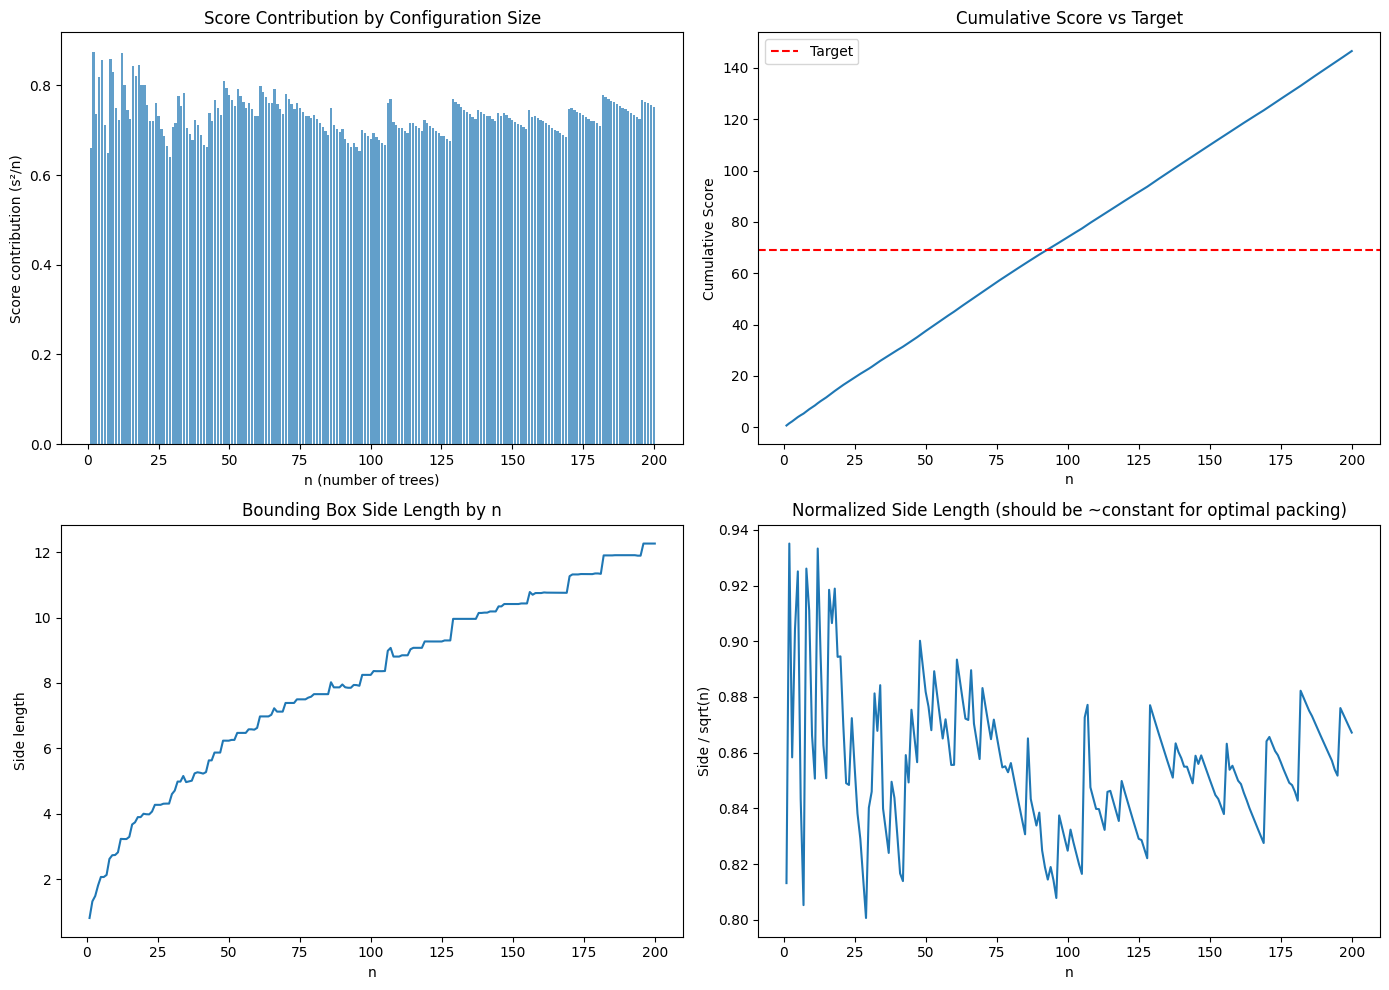


Top 10 worst configurations (highest score contribution):
  n=2: score=0.8743, side=1.3224
  n=12: score=0.8710, side=3.2330
  n=8: score=0.8576, side=2.6193
  n=5: score=0.8558, side=2.0685
  n=18: score=0.8444, side=3.8985
  n=16: score=0.8436, side=3.6738
  n=9: score=0.8300, side=2.7332
  n=17: score=0.8218, side=3.7376
  n=4: score=0.8179, side=1.8088
  n=48: score=0.8103, side=6.2365


In [5]:
# Analyze which n values contribute most to the score
import matplotlib.pyplot as plt

n_values = list(range(1, 201))
scores = [per_n_scores[n] for n in n_values]
sides = [per_n_sides[n] for n in n_values]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score contribution by n
axes[0, 0].bar(n_values, scores, alpha=0.7)
axes[0, 0].set_xlabel('n (number of trees)')
axes[0, 0].set_ylabel('Score contribution (s²/n)')
axes[0, 0].set_title('Score Contribution by Configuration Size')

# Cumulative score
cumulative = np.cumsum(scores)
axes[0, 1].plot(n_values, cumulative)
axes[0, 1].axhline(y=68.922808, color='r', linestyle='--', label='Target')
axes[0, 1].set_xlabel('n')
axes[0, 1].set_ylabel('Cumulative Score')
axes[0, 1].set_title('Cumulative Score vs Target')
axes[0, 1].legend()

# Side length by n
axes[1, 0].plot(n_values, sides)
axes[1, 0].set_xlabel('n')
axes[1, 0].set_ylabel('Side length')
axes[1, 0].set_title('Bounding Box Side Length by n')

# Side length / sqrt(n) - should be roughly constant for good packing
normalized_sides = [sides[i] / np.sqrt(n_values[i]) for i in range(len(n_values))]
axes[1, 1].plot(n_values, normalized_sides)
axes[1, 1].set_xlabel('n')
axes[1, 1].set_ylabel('Side / sqrt(n)')
axes[1, 1].set_title('Normalized Side Length (should be ~constant for optimal packing)')

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

print(f'\nTop 10 worst configurations (highest score contribution):')
sorted_scores = sorted(per_n_scores.items(), key=lambda x: x[1], reverse=True)
for n, score in sorted_scores[:10]:
    print(f'  n={n}: score={score:.4f}, side={per_n_sides[n]:.4f}')

In [6]:
# Compare with sample submission
sample_sub = load_submission('/home/data/sample_submission.csv')

sample_per_n_scores = {}
sample_per_n_sides = {}

for n in range(1, 201):
    group_data = sample_sub[sample_sub['n'] == n]
    trees = [ChristmasTree(str(row['x']), str(row['y']), str(row['deg'])) 
             for _, row in group_data.iterrows()]
    side = get_side_length(trees)
    sample_per_n_sides[n] = side
    sample_per_n_scores[n] = side**2 / n

sample_total = sum(sample_per_n_scores.values())
print(f'Sample submission score: {sample_total:.6f}')
print(f'Our best score: {total_score:.6f}')
print(f'Improvement over sample: {sample_total - total_score:.6f}')

Sample submission score: 173.652299
Our best score: 146.566822
Improvement over sample: 27.085477


In [7]:
# Calculate theoretical minimum based on tree area
# Tree area is approximately 0.35 * 1.0 = 0.35 (rough estimate)
# For n trees, minimum area needed is n * tree_area
# For a square, side = sqrt(n * tree_area)

tree_area = 0.35  # Approximate area of one tree
theoretical_min_scores = {}
for n in range(1, 201):
    min_side = np.sqrt(n * tree_area)
    theoretical_min_scores[n] = min_side**2 / n  # = tree_area (constant!)

theoretical_total = sum(theoretical_min_scores.values())
print(f'Theoretical minimum score (perfect packing): {theoretical_total:.6f}')
print(f'This assumes 100% packing efficiency, which is impossible for irregular shapes')
print(f'\nRealistic target based on public kernels: 67-70')

Theoretical minimum score (perfect packing): 70.000000
This assumes 100% packing efficiency, which is impossible for irregular shapes

Realistic target based on public kernels: 67-70
